In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

from skimage import exposure, util
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.morphology import binary_opening, binary_closing, square
import scipy.io as sio

In [2]:
data_path = "./glaucoma-detection/"
meta_path = os.path.join(data_path, "glaucoma.csv")
imgs_path = os.path.join(data_path, "ORIGA/ORIGA/Images/")
img_path = os.path.join(imgs_path, "*.jpg")
wkg_path = os.path.join(data_path, "working/")
save_path = os.path.join(wkg_path, "seg_images/")
os.makedirs(save_path, exist_ok=True)
ptmd_path = os.path.join(wkg_path, "pretrained_models/")
os.makedirs(ptmd_path, exist_ok=True)
rslt_path = os.path.join(data_path, "results/")
os.makedirs(rslt_path, exist_ok=True)

In [3]:
meta = pd.read_csv(meta_path)
meta

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0
...,...,...,...,...,...
645,646.jpg,0.6560,OD,A,1
646,647.jpg,0.7365,OD,A,1
647,648.jpg,0.5101,OS,A,1
648,649.jpg,0.5227,OD,B,0


In [4]:
all_images = glob(img_path)
meta["Path"] = meta["Filename"].apply(lambda fn: os.path.join(imgs_path, fn))
meta["SegPath"] = meta["Filename"].apply(lambda fn: os.path.join(save_path, fn))
meta.head()

,Filename,ExpCDR,Eye,Set,Glaucoma,Path,SegPath
0,001.jpg,0.7097,OD,A,0,./glaucoma-detection/ORIGA/ORIGA/Images/001.jpg,./glaucoma-detection/working/seg_images/001.jpg
1,002.jpg,0.6953,OS,A,0,./glaucoma-detection/ORIGA/ORIGA/Images/002.jpg,./glaucoma-detection/working/seg_images/002.jpg
2,003.jpg,0.9629,OS,A,0,./glaucoma-detection/ORIGA/ORIGA/Images/003.jpg,./glaucoma-detection/working/seg_images/003.jpg
3,004.jpg,0.7246,OD,A,0,./glaucoma-detection/ORIGA/ORIGA/Images/004.jpg,./glaucoma-detection/working/seg_images/004.jpg
4,005.jpg,0.6138,OS,A,0,./glaucoma-detection/ORIGA/ORIGA/Images/005.jpg,./glaucoma-detection/working/seg_images/005.jpg


In [5]:
meta["Glaucoma"].value_counts()

Glaucoma
0    482
1    168
Name: count, dtype: int64

In [6]:
meta.groupby("Glaucoma")["ExpCDR"].mean()

Glaucoma
0    0.542243
1    0.674040
Name: ExpCDR, dtype: float64

### Segment optic disc using kmeans

In [7]:
from segmentation import seg_kmeans_single
seg_kmeans_single(os.path.join(imgs_path, "001.jpg"), os.path.join(save_path, "001.jpg"))

Saved segmented optic disc → ./glaucoma-detection/working/seg_images/001.jpg


In [8]:
from segmentation import seg_kmeans_batch
seg_kmeans_batch(img_path, save_path) # different input and output path

  0%|          | 0/650 [00:00<?, ?it/s]

Finished processing all images!


In [23]:
meta_gl = meta.loc[meta["Glaucoma"] == 0]
meta_nl = meta.loc[meta["Glaucoma"] == 1]
new_meta = pd.concat([meta_gl.iloc[:170], meta_nl]).copy()
## reason?

### Divide train and test datasets

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
train_df, test_df = train_test_split(new_meta, test_size=0.25, random_state=0)
print(train_df.shape, test_df.shape)

(253, 7) (85, 7)


### Load datasets

In [26]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [27]:
class GlaucomaDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        self.data = self.get_data()

    def get_data(self):
        data = []
        for i, row in self.df.iterrows():
            label = row["Glaucoma"]
            exp_cdr = row["ExpCDR"]
            file_stem = Path(row["SegPath"]).stem
            name = f"{file_stem}.jpg"
            path = os.path.join(save_path, name)
            data.append(((path, exp_cdr), label))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        (img_path, exp_cdr), label = self.data[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        return (image, torch.FloatTensor([exp_cdr])), label

train_transforms = transforms.Compose([
    # transforms.Resize((392, 392), antialias=True),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.2),
    transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    # transforms.Resize((392, 392), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [28]:
train_data = GlaucomaDataset(train_df, train_transforms)
test_data = GlaucomaDataset(test_df, test_transforms)
b_size = 16
train_loader = DataLoader(train_data, batch_size=b_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=b_size, shuffle=False)

### Build model: EfficientNet and MobileNet

In [29]:
from torchvision import models
import torchvision.models as models
import timm

In [30]:
# 1. Use EfficientNet
class EfficientModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # load from local path due to huggingface connection problems
        mdpath = os.path.join(ptmd_path, "efficientnet_b3.pytorch_model.bin")
        state_dict = torch.load(mdpath, map_location=torch.device('cpu'))
        self.cnn_model = timm.create_model("efficientnet_b3", pretrained=False)
        
        self.cnn_model.load_state_dict(state_dict)
        self.cnn_model.reset_classifier(num_classes=0) 
        
        # Or download from huggingface directly
        # self.cnn_model = timm.create_model('efficientnet_b3',  pretrained=True, num_classes=0)
        # num_classes=0 will remove the final classification layer, directly returning features

        num_features = self.cnn_model.num_features

        # Reduce high-dimensional EfficientNet to 30D to match previous design
        # Add ReLU and Dropout to increase nonlinearity and prevent overfitting
        self.cnn_projection = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 30)
        )

        # Final layers
        self.final_layers = nn.Sequential(
            nn.Linear(30, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, *x):
        image, exp_cdr = x[0]
        x1 = self.cnn_model(image)
        x1 = self.cnn_projection(x1)
        x = self.final_layers(x1)
        return x

In [31]:
effmodel = EfficientModel()
effmodel = effmodel.to("cuda:0")

In [32]:
# 2. Use MobileNet
class MobileModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        mdpath = os.path.join(ptmd_path, "mobilenet_v3_large.pytorch_model.bin")
        state_dict = torch.load(mdpath, map_location=torch.device('cpu'))
        self.cnn_model = timm.create_model("mobilenetv3_large_100", pretrained=False)
        
        self.cnn_model.load_state_dict(state_dict)
        self.cnn_model.reset_classifier(num_classes=0) 

        # # the real feature does not equal num_features in mbnet
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            out = self.cnn_model(dummy)
            real_features = out.shape[1]

        self.cnn_projection = nn.Sequential(
            nn.Linear(real_features, 512), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 30)
        )

        # Final layers
        self.final_layers = nn.Sequential(
            nn.Linear(30, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, *x):
        image, exp_cdr = x[0]
        x1 = self.cnn_model(image)
        x1 = self.cnn_projection(x1)
        x = self.final_layers(x1)
        return x

In [33]:
mobmodel = MobileModel()
mobmodel = mobmodel.to("cuda:0")

### Fine tuning

In [34]:
from fastai.vision.all import *
# Load LabelSmoothingCrossEntropy which performs better in medical images than cross entropy
from fastai.losses import LabelSmoothingCrossEntropy
from fastai.metrics import accuracy, Recall, Precision, F1Score, RocAucBinary

In [35]:
def ft_train(model, name):
    # Define learner
    learner = Learner(DataLoaders(train_loader, test_loader), model, path=rslt_path,
                      metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()],
                      loss_func=LabelSmoothingCrossEntropy())

    # Define callback function
    save_best = SaveModelCallback(monitor='f1_score', fname=f'ft_{name}_for_glaucoma_detection')

    early_stop = EarlyStoppingCallback(monitor='f1_score', min_delta=0.005, patience=15)

    print("Start fine tunning")

    learner.fine_tune(epochs=50, base_lr=1e-3, freeze_epochs=3, cbs=[early_stop, save_best])
    
    MODEL_FNAME = f'ft_{name}_for_glaucoma_detection'
    
    learner.load(MODEL_FNAME)

    print(f"Successfully load the best weights：{learner.path}/models/{MODEL_FNAME}.pth")

    # Evaluat using learner.validate()
    results = learner.validate()

    print("\n--- Validation（Test Loader）Evaluation ---")
    print(f"Valid Loss: {results[0]:.4f}")
    print(f"Accuracy: {results[1]:.4f}")
    print(f"Recall: {results[2]:.4f}")
    print(f"Precision: {results[3]:.4f}")
    print(f"F1 Score: {results[4]:.4f}")
    print(f"ROC-AUC: {results[5]:.4f}")

In [36]:
ft_train(effmodel, "efficientnet")

Start fine tunning


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.688078,0.679545,0.623529,0.973684,0.544118,0.698113,0.790594,00:03
1,0.623353,0.598801,0.811765,0.684211,0.866667,0.764706,0.867861,00:03
2,0.542424,0.856384,0.776471,0.631579,0.827586,0.716418,0.760358,00:03


Better model found at epoch 0 with f1_score value: 0.6981132075471699.
Better model found at epoch 1 with f1_score value: 0.7647058823529413.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.365313,0.497673,0.835294,0.842105,0.800000,0.820513,0.885778,00:03
1,0.317265,0.508485,0.823529,0.842105,0.780488,0.810127,0.882419,00:03
2,0.293076,0.495923,0.811765,0.736842,0.823529,0.777778,0.890817,00:03
3,0.270522,0.505149,0.811765,0.763158,0.805556,0.783784,0.888018,00:03
4,0.257016,0.498011,0.823529,0.789474,0.810811,0.800000,0.890817,00:03
5,0.246500,0.484263,0.835294,0.789474,0.833333,0.810811,0.901456,00:03
6,0.242896,0.525091,0.823529,0.815789,0.794872,0.805195,0.878499,00:03
7,0.254875,0.565756,0.788235,0.789474,0.750000,0.769231,0.842105,00:03
8,0.266513,0.527789,0.823529,0.894737,0.755556,0.819277,0.863942,00:03
9,0.274109,0.479406,0.847059,0.894737,0.790698,0.839506,0.917693,00:03


Better model found at epoch 0 with f1_score value: 0.8205128205128205.
Better model found at epoch 9 with f1_score value: 0.8395061728395061.
Better model found at epoch 13 with f1_score value: 0.8450704225352113.
No improvement since epoch 13: early stopping
Successfully load the best weights：glaucoma-detection/results/models/ft_efficientnet_for_glaucoma_detection.pth



--- Validation（Test Loader）Evaluation ---
Valid Loss: 0.4535
Accuracy: 0.8706
Recall: 0.7895
Precision: 0.9091
F1 Score: 0.8451
ROC-AUC: 0.9048


In [37]:
ft_train(mobmodel, "mobilenet")

Start fine tunning


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.705723,0.724836,0.447059,1.000000,0.447059,0.617886,0.734043,00:02
1,0.676318,0.548523,0.776471,0.710526,0.771429,0.739726,0.817469,00:02
2,0.598054,0.528270,0.741176,0.763158,0.690476,0.725000,0.849384,00:02


Better model found at epoch 0 with f1_score value: 0.6178861788617886.
Better model found at epoch 1 with f1_score value: 0.7397260273972601.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.485938,0.543165,0.717647,0.710526,0.675000,0.692308,0.833707,00:01
1,0.427153,0.572388,0.764706,0.842105,0.695652,0.761905,0.857223,00:02
2,0.380522,0.556189,0.776471,0.842105,0.711111,0.771084,0.878499,00:02
3,0.345467,0.601891,0.788235,0.868421,0.717391,0.785714,0.876820,00:02
4,0.313535,0.608048,0.752941,0.868421,0.673469,0.758621,0.885778,00:02
5,0.290674,0.592514,0.752941,0.842105,0.680851,0.752941,0.880179,00:02
6,0.270987,0.625002,0.764706,0.868421,0.687500,0.767442,0.860582,00:02
7,0.258571,0.659014,0.752941,0.842105,0.680851,0.752941,0.858343,00:02
8,0.254660,0.591609,0.800000,0.868421,0.733333,0.795181,0.862822,00:01
9,0.247301,0.561104,0.811765,0.789474,0.789474,0.789474,0.884099,00:02


Better model found at epoch 0 with f1_score value: 0.6923076923076923.
Better model found at epoch 1 with f1_score value: 0.761904761904762.
Better model found at epoch 2 with f1_score value: 0.7710843373493975.
Better model found at epoch 3 with f1_score value: 0.7857142857142858.
Better model found at epoch 8 with f1_score value: 0.7951807228915663.
Better model found at epoch 17 with f1_score value: 0.810126582278481.
No improvement since epoch 17: early stopping
Successfully load the best weights：glaucoma-detection/results/models/ft_mobilenet_for_glaucoma_detection.pth



--- Validation（Test Loader）Evaluation ---
Valid Loss: 0.5494
Accuracy: 0.8235
Recall: 0.8421
Precision: 0.7805
F1 Score: 0.8101
ROC-AUC: 0.9003


### Evaluation and visualization

In [38]:
def plot_training_history(learner,fold, ptmodel, title="Training History"):
    """
    Extract data from FastAI Learner and plot Loss and Metrics curves.
    """
    values = np.array(learner.recorder.values)
    metric_names = learner.recorder.metric_names

    # FastAI's metric_names used to be ['epoch', 'train_loss', 'valid_loss', 'accuracy', 'f1_score', 'roc_auc_binary', ...]
    # Automatically find
    try:
        idx_train_loss = metric_names.index('train_loss') - 1
        idx_valid_loss = metric_names.index('valid_loss') - 1
        idx_f1 = metric_names.index('f1_score') - 1
        idx_auc = metric_names.index('roc_auc_score') - 1
    except ValueError:
        print("Error: Cannot find the index, please check: learner.recorder.metric_names")
        print("Current available indeces:", metric_names)
        return

    train_losses = values[:, idx_train_loss]
    valid_losses = values[:, idx_valid_loss]
    f1_scores = values[:, idx_f1]
    auc_scores = values[:, idx_auc]
    epochs = range(1, len(train_losses) + 1)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Loss
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, valid_losses, 'r--', label='Valid Loss', linewidth=2)
    ax1.set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Mark the lowest loss point
    min_loss_idx = np.argmin(valid_losses)
    ax1.scatter(epochs[min_loss_idx], valid_losses[min_loss_idx], s=100, c='red', marker='*')

    # Metrics (F1 & AUC)
    ax2.plot(epochs, f1_scores, 'g-', label='F1 Score', linewidth=2, marker='.')
    ax2.plot(epochs, auc_scores, 'purple', label='ROC-AUC', linewidth=2, linestyle='--', marker='.')

    ax2.set_title(f'{title} - Metrics', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('F1_Score', fontsize=12)
    ax2.set_ylim(0, 1.05) 
    ax2.legend(fontsize=12, loc='lower right')
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Mark the best F1 point
    max_f1_idx = np.argmax(f1_scores)
    ax2.scatter(epochs[max_f1_idx], f1_scores[max_f1_idx], s=100, c='green', marker='*')
    SAVE_FILENAME = os.path.join(rslt_path, f'{ptmodel}_KFold_Training_Curves_{fold+1}.png')
    plt.savefig(SAVE_FILENAME, dpi=300, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

### K-Fold

In [39]:
from sklearn.model_selection import KFold, StratifiedKFold

In [40]:
OUTPUT_DIR = Path(rslt_path)

df = new_meta

N_SPLITS = 5 
RANDOM_STATE = 42

kf = StratifiedKFold(n_splits=N_SPLITS, 
                     shuffle=True, 
                     random_state=RANDOM_STATE) # Ensure similar label proportion of each fold


--- Pretrained Model: EfficientNet_b3 ---

--- 🚀 Starting Fold 1/5 ---
Fold 1: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.693233,0.690146,0.500000,0.000000,0.000000,0.000000,0.693772,00:04
1,0.600757,1.148282,0.632353,0.764706,0.604651,0.675325,0.707612,00:03
2,0.549187,0.727440,0.647059,0.558824,0.678571,0.612903,0.750000,00:03


Better model found at epoch 0 with f1_score value: 0.0.
Better model found at epoch 1 with f1_score value: 0.6753246753246753.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.365035,0.644451,0.676471,0.647059,0.687500,0.666667,0.769896,00:03
1,0.328848,0.786383,0.720588,0.705882,0.727273,0.716418,0.737889,00:03
2,0.301350,1.076354,0.647059,0.941176,0.592593,0.727273,0.713668,00:03
3,0.307475,0.905811,0.632353,0.588235,0.645161,0.615385,0.736159,00:03
4,0.304441,0.777874,0.676471,0.647059,0.687500,0.666667,0.757785,00:03
5,0.300079,0.817877,0.647059,0.735294,0.625000,0.675676,0.733564,00:04
6,0.283200,0.761892,0.735294,0.588235,0.833333,0.689655,0.770761,00:03
7,0.284301,0.763395,0.705882,0.647059,0.733333,0.687500,0.759516,00:04
8,0.272645,0.754773,0.691176,0.676471,0.696970,0.686567,0.747405,00:04
9,0.261941,0.740133,0.691176,0.676471,0.696970,0.686567,0.751730,00:03


Better model found at epoch 0 with f1_score value: 0.6666666666666667.
Better model found at epoch 1 with f1_score value: 0.7164179104477613.
Better model found at epoch 2 with f1_score value: 0.7272727272727272.


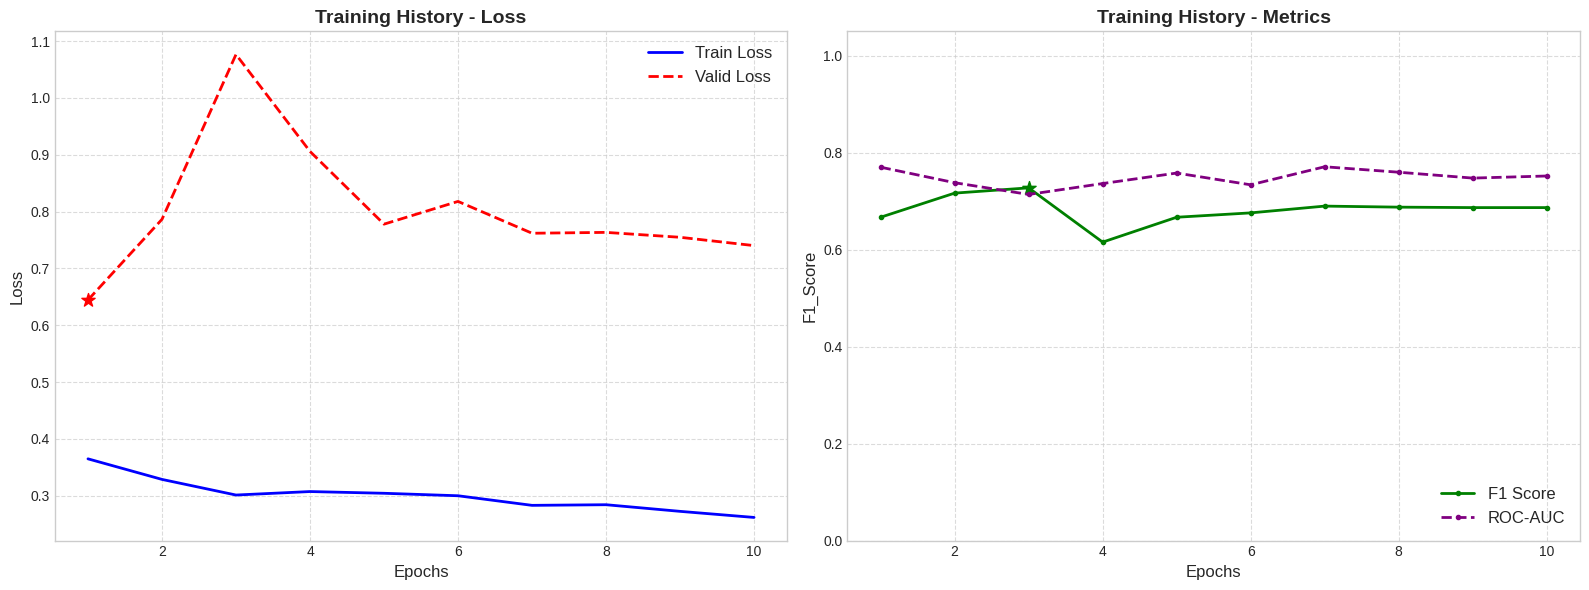

✅ Fold 1 Completed. F1 Score: 0.7273, AUC: 0.7137

--- 🚀 Starting Fold 2/5 ---
Fold 2: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.692426,0.683274,0.500000,0.000000,0.000000,0.000000,0.799308,00:03
1,0.614329,1.326078,0.602941,0.294118,0.769231,0.425532,0.807958,00:03
2,0.568828,0.737396,0.514706,0.500000,0.515152,0.507463,0.547578,00:04


Better model found at epoch 0 with f1_score value: 0.0.
Better model found at epoch 1 with f1_score value: 0.4255319148936171.
Better model found at epoch 2 with f1_score value: 0.5074626865671642.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.446623,0.615834,0.676471,0.529412,0.750000,0.620690,0.840830,00:03
1,0.375777,0.616999,0.808824,0.941176,0.744186,0.831169,0.815744,00:03
2,0.338289,0.700641,0.705882,0.588235,0.769231,0.666667,0.816609,00:03
3,0.336042,0.811619,0.676471,0.735294,0.657895,0.694444,0.793253,00:03
4,0.340241,0.765702,0.647059,0.529412,0.692308,0.600000,0.779412,00:03
5,0.341562,0.623871,0.779412,0.794118,0.771429,0.782609,0.841696,00:03
6,0.321984,0.730665,0.705882,0.558824,0.791667,0.655172,0.813149,00:03
7,0.302307,0.666357,0.764706,0.705882,0.800000,0.750000,0.826125,00:03
8,0.279749,0.685103,0.735294,0.647059,0.785714,0.709677,0.811419,00:03
9,0.263174,0.687867,0.735294,0.647059,0.785714,0.709677,0.810554,00:03


Better model found at epoch 0 with f1_score value: 0.6206896551724139.
Better model found at epoch 1 with f1_score value: 0.8311688311688312.


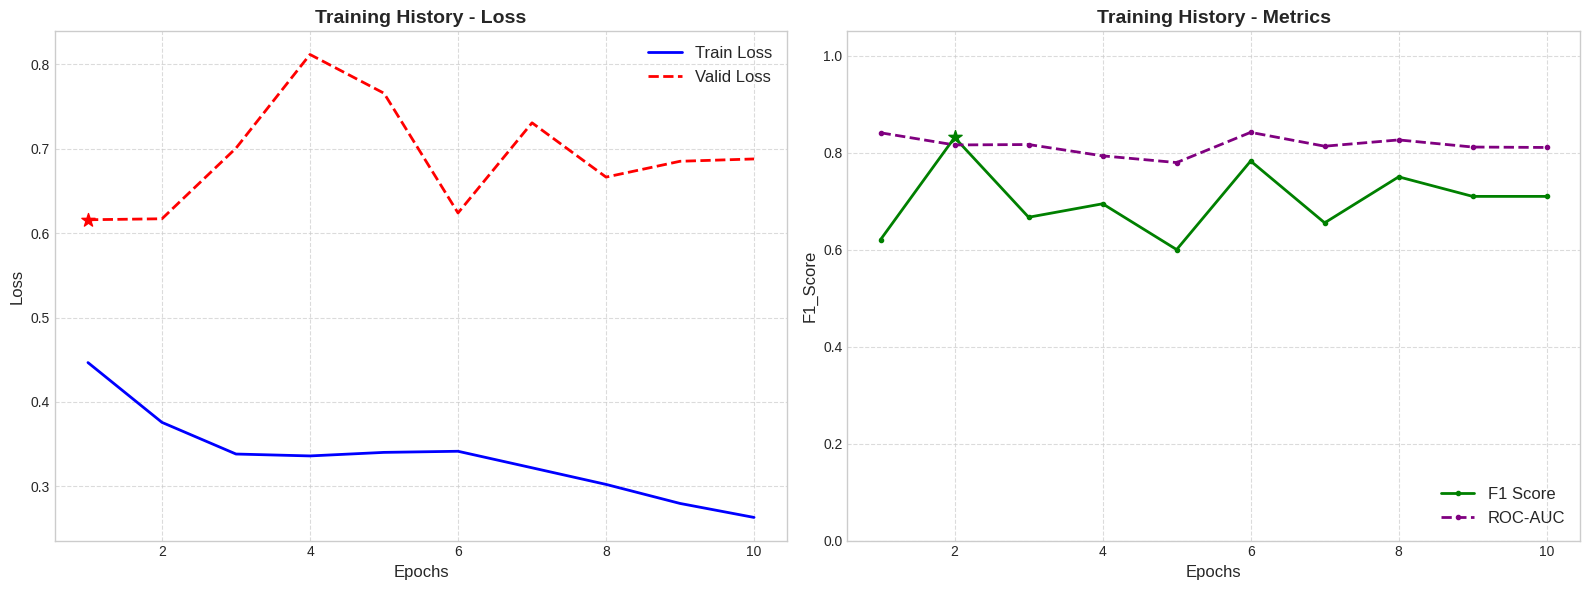

✅ Fold 2 Completed. F1 Score: 0.8312, AUC: 0.8157

--- 🚀 Starting Fold 3/5 ---
Fold 3: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.687451,0.613889,0.838235,0.735294,0.925926,0.819672,0.946367,00:03
1,0.640216,0.711057,0.529412,0.911765,0.516667,0.659574,0.510381,00:03
2,0.634647,0.700115,0.544118,0.970588,0.523810,0.680412,0.729239,00:03


Better model found at epoch 0 with f1_score value: 0.819672131147541.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.565335,0.517389,0.823529,0.705882,0.923077,0.800000,0.933391,00:03
1,0.502437,0.463791,0.897059,0.823529,0.965517,0.888889,0.970588,00:03
2,0.495045,0.462108,0.882353,0.764706,1.000000,0.866667,0.968858,00:03
3,0.472028,0.500453,0.867647,0.735294,1.000000,0.847458,0.916090,00:03
4,0.430285,0.362414,0.911765,0.852941,0.966667,0.906250,0.945502,00:03
5,0.391948,0.575669,0.779412,0.882353,0.731707,0.800000,0.894464,00:03
6,0.372607,0.371503,0.882353,0.794118,0.964286,0.870968,0.954152,00:03
7,0.338428,0.318519,0.941176,0.941176,0.941176,0.941176,0.977509,00:03
8,0.306375,0.311192,0.941176,0.911765,0.968750,0.939394,0.977509,00:04
9,0.285138,0.320383,0.941176,0.911765,0.968750,0.939394,0.975779,00:04


Better model found at epoch 0 with f1_score value: 0.8000000000000002.
Better model found at epoch 1 with f1_score value: 0.888888888888889.
Better model found at epoch 4 with f1_score value: 0.90625.
Better model found at epoch 7 with f1_score value: 0.9411764705882353.


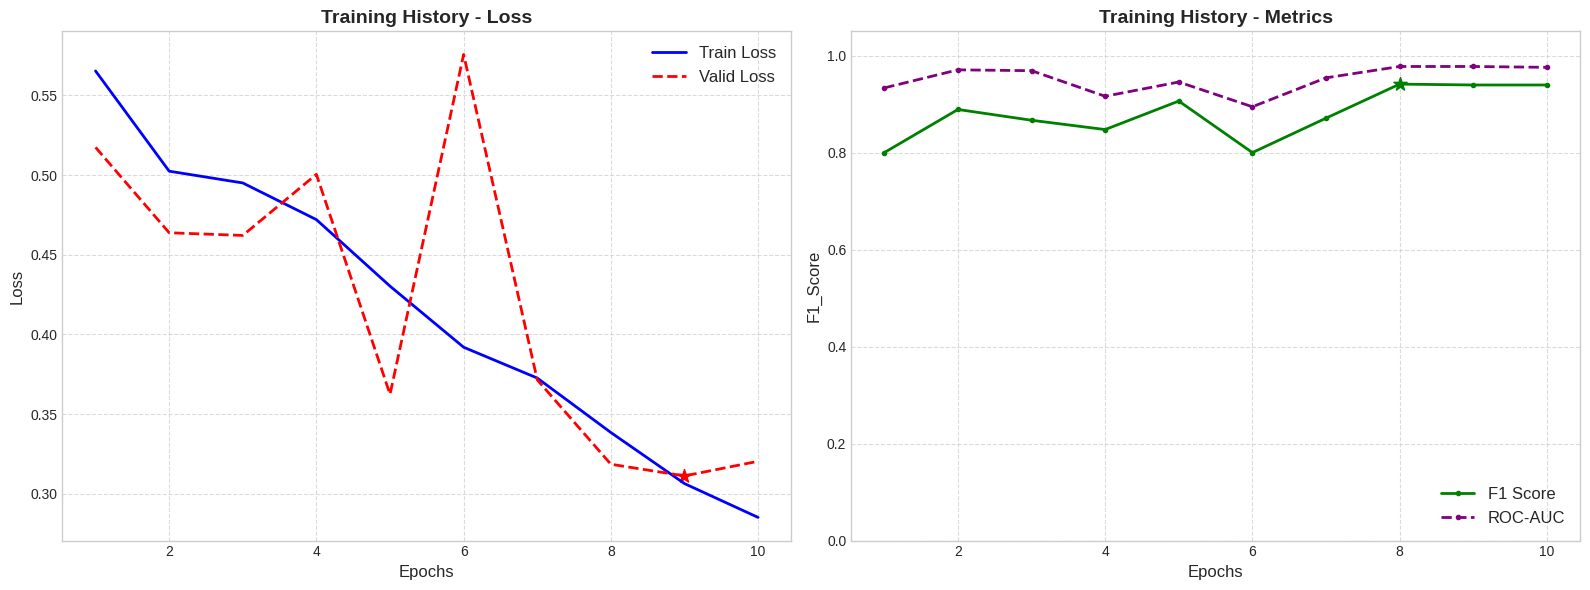

✅ Fold 3 Completed. F1 Score: 0.9412, AUC: 0.9775

--- 🚀 Starting Fold 4/5 ---
Fold 4: Train size=271, Validation size=67


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.683073,0.621571,0.597015,0.393939,0.650000,0.490566,0.785205,00:04
1,0.614555,0.684528,0.761194,0.696970,0.793103,0.741935,0.839572,00:03
2,0.563477,9.773856,0.611940,0.303030,0.769231,0.434783,0.713904,00:03


Better model found at epoch 0 with f1_score value: 0.490566037735849.
Better model found at epoch 1 with f1_score value: 0.7419354838709677.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.455782,0.475028,0.850746,0.787879,0.896552,0.838710,0.917112,00:03
1,0.384850,0.403115,0.865672,0.878788,0.852941,0.865672,0.952763,00:03
2,0.362533,0.524168,0.820895,0.939394,0.756098,0.837838,0.919786,00:03
3,0.364808,0.528765,0.850746,0.818182,0.870968,0.843750,0.903743,00:03
4,0.379195,0.439492,0.850746,0.939394,0.794872,0.861111,0.934046,00:03
5,0.356026,0.421331,0.865672,0.878788,0.852941,0.865672,0.941176,00:03
6,0.327459,0.457414,0.835821,0.757576,0.892857,0.819672,0.919786,00:03
7,0.302831,0.471750,0.791045,0.757576,0.806452,0.781250,0.915330,00:03
8,0.283235,0.472196,0.791045,0.757576,0.806452,0.781250,0.921569,00:03
9,0.264189,0.465751,0.805970,0.757576,0.833333,0.793651,0.921569,00:04


Better model found at epoch 0 with f1_score value: 0.8387096774193549.
Better model found at epoch 1 with f1_score value: 0.8656716417910447.


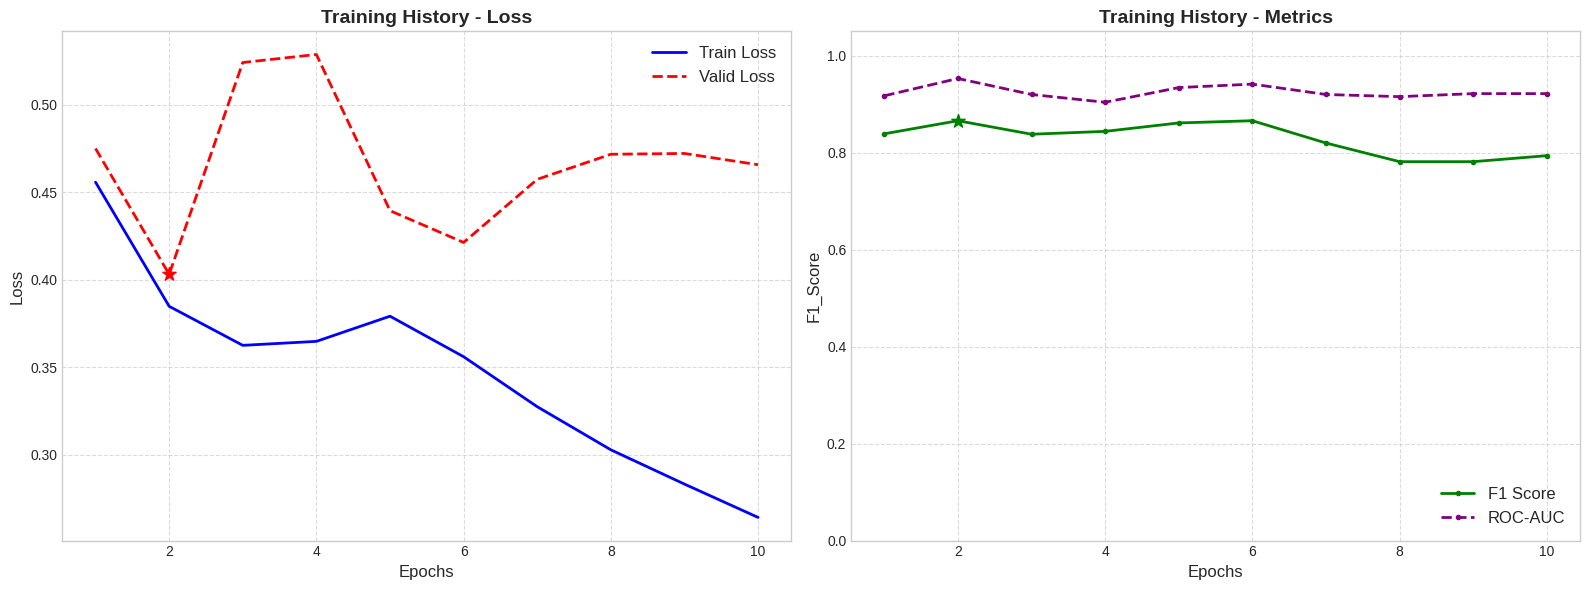

✅ Fold 4 Completed. F1 Score: 0.8657, AUC: 0.9528

--- 🚀 Starting Fold 5/5 ---
Fold 5: Train size=271, Validation size=67


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.732017,0.722573,0.492537,1.000000,0.492537,0.660000,0.865419,00:03
1,0.664676,0.580284,0.716418,0.969697,0.640000,0.771084,0.853832,00:03
2,0.612499,0.726316,0.701493,0.393939,1.000000,0.565217,0.848485,00:03


Better model found at epoch 0 with f1_score value: 0.66.
Better model found at epoch 1 with f1_score value: 0.7710843373493975.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.417999,0.538019,0.776119,0.878788,0.725000,0.794521,0.881462,00:03
1,0.344846,0.782692,0.731343,0.939394,0.659574,0.775000,0.901961,00:03
2,0.334308,0.471285,0.850746,0.757576,0.925926,0.833333,0.891266,00:03
3,0.333878,0.542856,0.746269,0.545455,0.900000,0.679245,0.844029,00:03
4,0.328735,0.583192,0.776119,0.848485,0.736842,0.788732,0.860071,00:04
5,0.309709,0.628069,0.791045,0.787879,0.787879,0.787879,0.875223,00:03
6,0.289892,0.608562,0.761194,0.848485,0.717949,0.777778,0.861854,00:03
7,0.283941,0.593821,0.791045,0.848485,0.756757,0.800000,0.859180,00:04
8,0.268250,0.563891,0.820895,0.848485,0.800000,0.823529,0.872549,00:03
9,0.266063,0.572557,0.805970,0.848485,0.777778,0.811594,0.873440,00:03


Better model found at epoch 0 with f1_score value: 0.7945205479452054.
Better model found at epoch 2 with f1_score value: 0.8333333333333334.


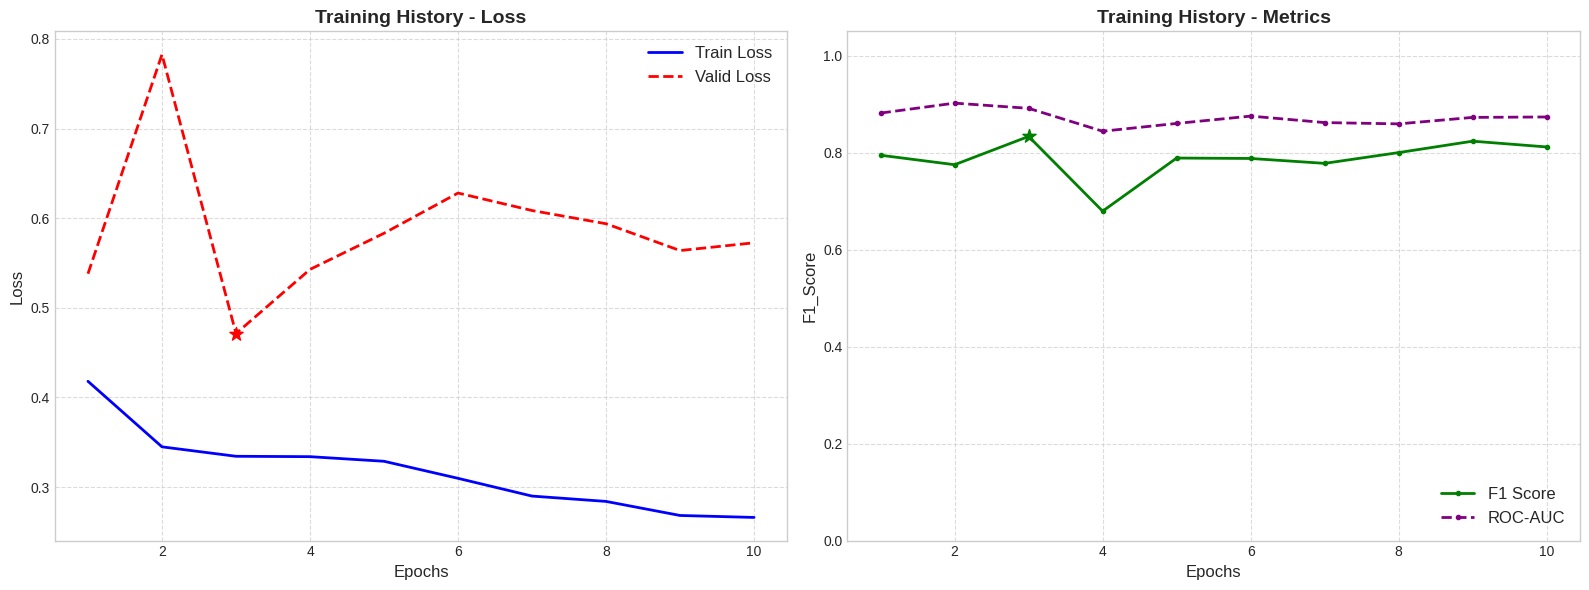

✅ Fold 5 Completed. F1 Score: 0.8333, AUC: 0.8913

--- K-Fold Evaluation ---
   Fold        F1       AUC
0     1  0.727273  0.713668
1     2  0.831169  0.815744
2     3  0.941176  0.977509
3     4  0.865672  0.952763
4     5  0.833333  0.891266
------------------------
Average F1 Score: 0.8397 ± 0.0770
Average AUC Score: 0.8702 ± 0.1075


In [41]:
print(f"\n--- Pretrained Model: EfficientNet_b3 ---")

all_fold_metrics_eff = []
# Main loop
for fold, (train_index, val_index) in enumerate(kf.split(df, df['Glaucoma'])):

    print(f"\n--- 🚀 Starting Fold {fold+1}/{N_SPLITS} ---")

    train_df = df.iloc[train_index].reset_index(drop=True)
    val_df = df.iloc[val_index].reset_index(drop=True)

    print(f"Fold {fold+1}: Train size={len(train_df)}, Validation size={len(val_df)}")

    train_ds = GlaucomaDataset(train_df, train_transforms)
    val_ds = GlaucomaDataset(val_df, test_transforms)

    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=16)
    dls = DataLoaders(train_dl, val_dl)

    # Intialize the model
    torch.cuda.empty_cache()
    effmodel = EfficientModel()
    effmodel = effmodel.to("cuda:0")
    
    learner = Learner(dls, effmodel, path=OUTPUT_DIR,
              metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()],
              loss_func=LabelSmoothingCrossEntropyFlat()
                    )

    save_cb = SaveModelCallback(monitor='f1_score', fname=f'fold_{fold+1}_bst_efficientnet', comp=np.greater)
    early_cb = EarlyStoppingCallback(monitor='f1_score', min_delta=0.005, patience=15)

    # Train and save the best model
    learner.fine_tune(
        epochs=10,
        base_lr=2e-3,
        freeze_epochs=3,
        cbs=[save_cb, early_cb]
    )
    plot_training_history(learner,fold,"EfficientNet_b3")

    # Validate and record results
    learner.load(f'fold_{fold+1}_bst_efficientnet') 
    metrics = learner.validate()

    f1_score = metrics[4]
    roc_auc = metrics[5]
    all_fold_metrics_eff.append({'Fold': fold+1, 'F1': f1_score, 'AUC': roc_auc})

    print(f"✅ Fold {fold+1} Completed. F1 Score: {f1_score:.4f}, AUC: {roc_auc:.4f}")

final_results_df = pd.DataFrame(all_fold_metrics_eff)
print("\n--- K-Fold Evaluation ---")
print(final_results_df)
print("------------------------")
print(f"Average F1 Score: {final_results_df['F1'].mean():.4f} ± {final_results_df['F1'].std():.4f}")
print(f"Average AUC Score: {final_results_df['AUC'].mean():.4f} ± {final_results_df['AUC'].std():.4f}")


--- Pretrained Model: MobileNet_v3 ---

--- 🚀 Starting Fold 1/5 ---
Fold 1: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.699170,0.684478,0.558824,0.235294,0.666667,0.347826,0.654844,00:02
1,0.625564,0.700395,0.705882,0.794118,0.675000,0.729730,0.673010,00:02
2,0.580400,0.842074,0.661765,0.529412,0.720000,0.610169,0.773356,00:02


Better model found at epoch 0 with f1_score value: 0.3478260869565218.
Better model found at epoch 1 with f1_score value: 0.7297297297297296.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.405969,0.743185,0.647059,0.705882,0.631579,0.666667,0.729239,00:02
1,0.374897,0.630053,0.705882,0.558824,0.791667,0.655172,0.782007,00:02
2,0.345822,0.849100,0.617647,0.676471,0.605263,0.638889,0.717128,00:02
3,0.316629,1.025198,0.720588,0.941176,0.653061,0.771084,0.740484,00:02
4,0.315336,0.818445,0.676471,0.676471,0.676471,0.676471,0.736159,00:02
5,0.296848,0.834020,0.661765,0.647059,0.666667,0.656716,0.737024,00:02
6,0.294736,0.813746,0.647059,0.705882,0.631579,0.666667,0.729239,00:02
7,0.280949,0.732453,0.735294,0.705882,0.750000,0.727273,0.762111,00:02
8,0.263622,0.746874,0.750000,0.676471,0.793103,0.730159,0.775087,00:02
9,0.254892,0.772442,0.720588,0.617647,0.777778,0.688525,0.778547,00:02


Better model found at epoch 0 with f1_score value: 0.6666666666666667.
Better model found at epoch 3 with f1_score value: 0.7710843373493975.


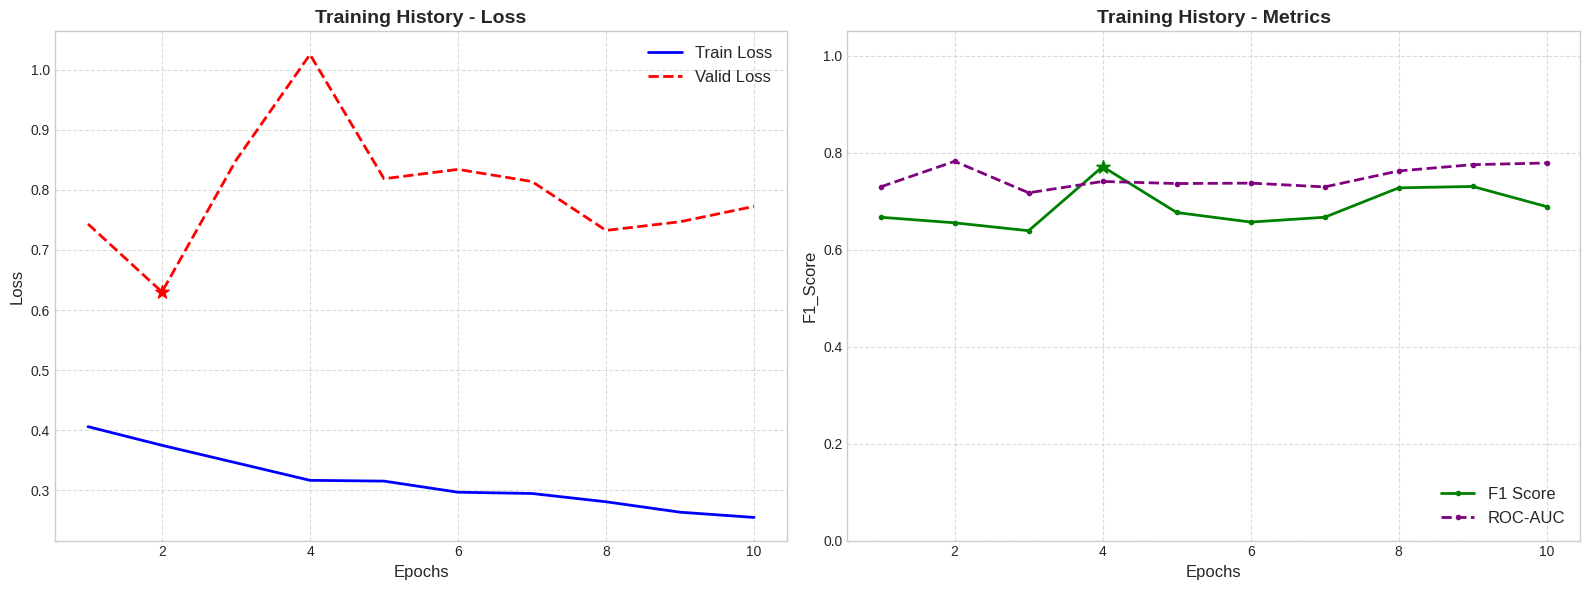

✅ Fold 1 Completed. F1 Score: 0.7711, AUC: 0.7405

--- 🚀 Starting Fold 2/5 ---
Fold 2: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.685776,0.683684,0.500000,0.000000,0.000000,0.000000,0.666090,00:02
1,0.630152,0.637364,0.691176,0.852941,0.644444,0.734177,0.768166,00:02
2,0.564468,3.389067,0.602941,0.205882,1.000000,0.341463,0.753460,00:02


Better model found at epoch 0 with f1_score value: 0.0.
Better model found at epoch 1 with f1_score value: 0.7341772151898734.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.447742,0.660348,0.720588,0.588235,0.800000,0.677966,0.833045,00:02
1,0.383017,0.684962,0.750000,0.705882,0.774194,0.738462,0.843426,00:02
2,0.335220,0.821130,0.691176,0.705882,0.685714,0.695652,0.735294,00:02
3,0.342800,0.957887,0.676471,0.411765,0.875000,0.560000,0.857266,00:02
4,0.325983,0.722047,0.735294,0.529412,0.900000,0.666667,0.822664,00:02
5,0.298728,0.616562,0.808824,0.794118,0.818182,0.805970,0.826990,00:02
6,0.279781,0.771312,0.735294,0.588235,0.833333,0.689655,0.819204,00:02
7,0.262975,0.753429,0.720588,0.588235,0.800000,0.677966,0.843426,00:02
8,0.252314,0.786463,0.705882,0.529412,0.818182,0.642857,0.842561,00:02
9,0.241838,0.764260,0.735294,0.588235,0.833333,0.689655,0.839965,00:02


Better model found at epoch 0 with f1_score value: 0.6779661016949153.
Better model found at epoch 1 with f1_score value: 0.7384615384615385.
Better model found at epoch 5 with f1_score value: 0.8059701492537314.


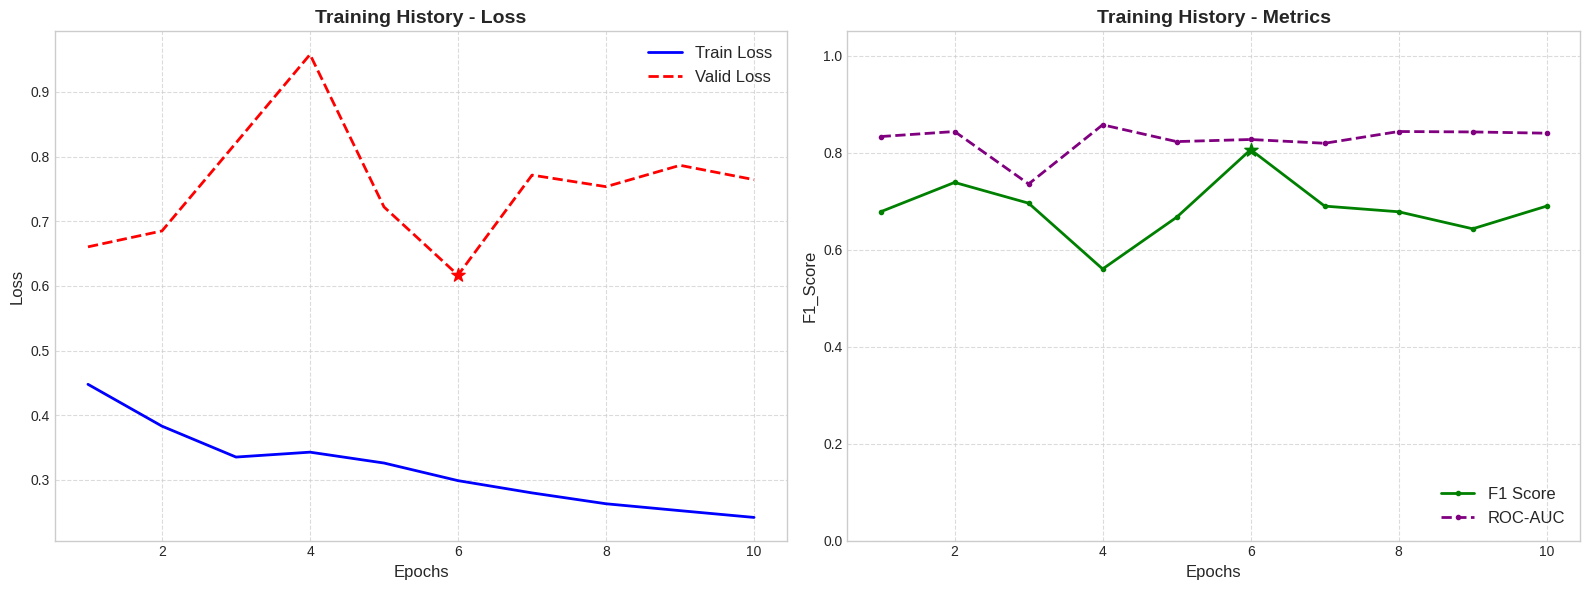

✅ Fold 2 Completed. F1 Score: 0.8060, AUC: 0.8270

--- 🚀 Starting Fold 3/5 ---
Fold 3: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.687437,0.662459,0.867647,0.794118,0.931034,0.857143,0.959343,00:02
1,0.628354,0.510602,0.794118,1.000000,0.708333,0.829268,0.955882,00:02
2,0.594934,0.505831,0.911765,0.852941,0.966667,0.906250,0.970588,00:02


Better model found at epoch 0 with f1_score value: 0.8571428571428571.
Better model found at epoch 2 with f1_score value: 0.90625.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.445441,0.388113,0.867647,0.764706,0.962963,0.852459,0.970588,00:02
1,0.386127,0.356949,0.911765,0.882353,0.937500,0.909091,0.965398,00:02
2,0.360479,0.412550,0.897059,0.852941,0.935484,0.892308,0.961938,00:02
3,0.350121,0.380853,0.882353,0.852941,0.906250,0.878788,0.967993,00:02
4,0.329104,0.325318,0.970588,1.000000,0.944444,0.971429,0.985294,00:02
5,0.304965,0.343201,0.897059,0.882353,0.909091,0.895522,0.972318,00:02
6,0.288508,0.443697,0.852941,0.823529,0.875000,0.848485,0.925606,00:02
7,0.277479,0.378638,0.897059,0.852941,0.935484,0.892308,0.961938,00:02
8,0.265036,0.350508,0.911765,0.882353,0.937500,0.909091,0.970588,00:02
9,0.254790,0.354223,0.911765,0.882353,0.937500,0.909091,0.967128,00:02


Better model found at epoch 0 with f1_score value: 0.8524590163934426.
Better model found at epoch 1 with f1_score value: 0.9090909090909091.
Better model found at epoch 4 with f1_score value: 0.9714285714285714.


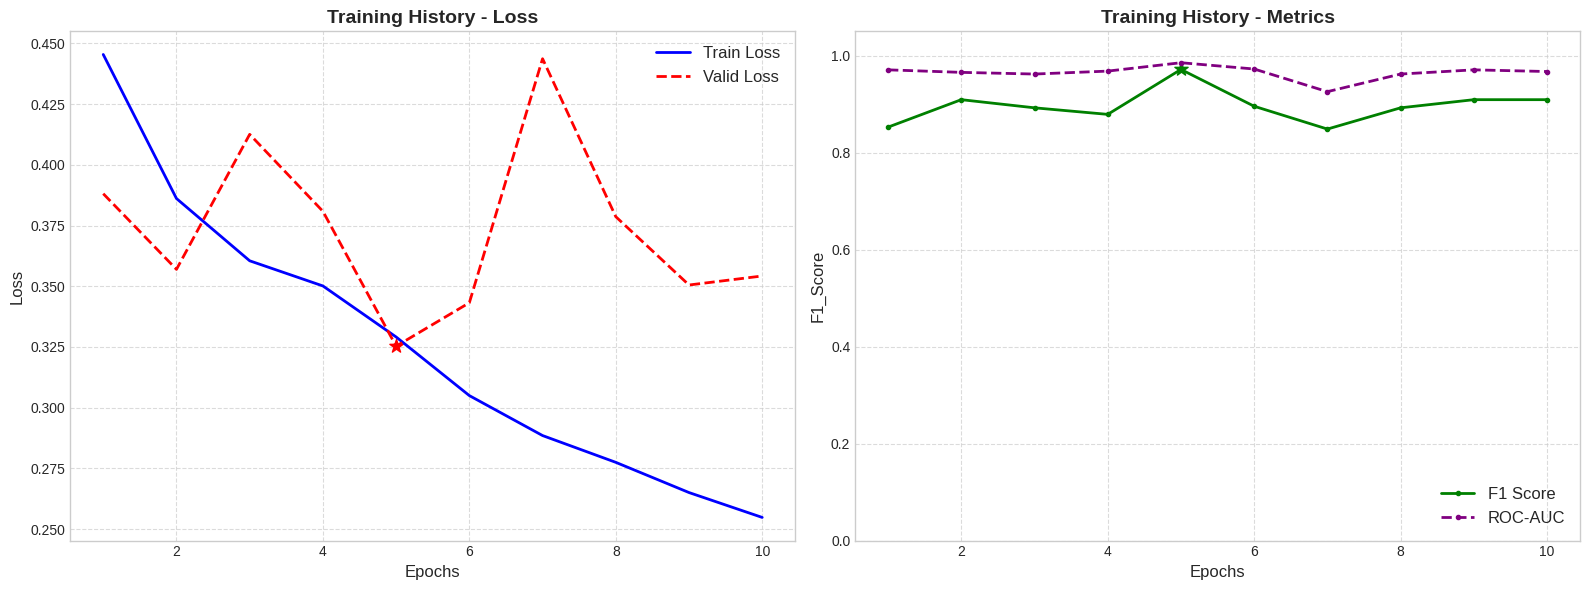

✅ Fold 3 Completed. F1 Score: 0.9714, AUC: 0.9853

--- 🚀 Starting Fold 4/5 ---
Fold 4: Train size=271, Validation size=67


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.681264,0.638519,0.671642,0.545455,0.720000,0.620690,0.805704,00:02
1,0.618206,0.539838,0.746269,0.969697,0.666667,0.790123,0.906417,00:02
2,0.560046,0.418716,0.880597,0.969697,0.820513,0.888889,0.933155,00:02


Better model found at epoch 0 with f1_score value: 0.6206896551724138.
Better model found at epoch 1 with f1_score value: 0.7901234567901234.
Better model found at epoch 2 with f1_score value: 0.8888888888888888.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.369627,0.412012,0.895522,0.848485,0.933333,0.888889,0.942068,00:02
1,0.317542,0.364507,0.865672,0.878788,0.852941,0.865672,0.967914,00:02
2,0.319946,0.617539,0.761194,0.909091,0.697674,0.789474,0.827094,00:02
3,0.312848,0.518145,0.761194,0.757576,0.757576,0.757576,0.909982,00:02
4,0.299588,0.579139,0.776119,0.969697,0.695652,0.810127,0.922460,00:02
5,0.298487,0.474551,0.850746,0.818182,0.870968,0.843750,0.899287,00:02
6,0.283472,0.385688,0.910448,0.969697,0.864865,0.914286,0.942959,00:02
7,0.273314,0.377363,0.880597,0.848485,0.903226,0.875000,0.945633,00:02
8,0.262741,0.383392,0.880597,0.878788,0.878788,0.878788,0.947415,00:02
9,0.250528,0.382223,0.865672,0.848485,0.875000,0.861538,0.947415,00:02


Better model found at epoch 0 with f1_score value: 0.888888888888889.
Better model found at epoch 6 with f1_score value: 0.9142857142857143.


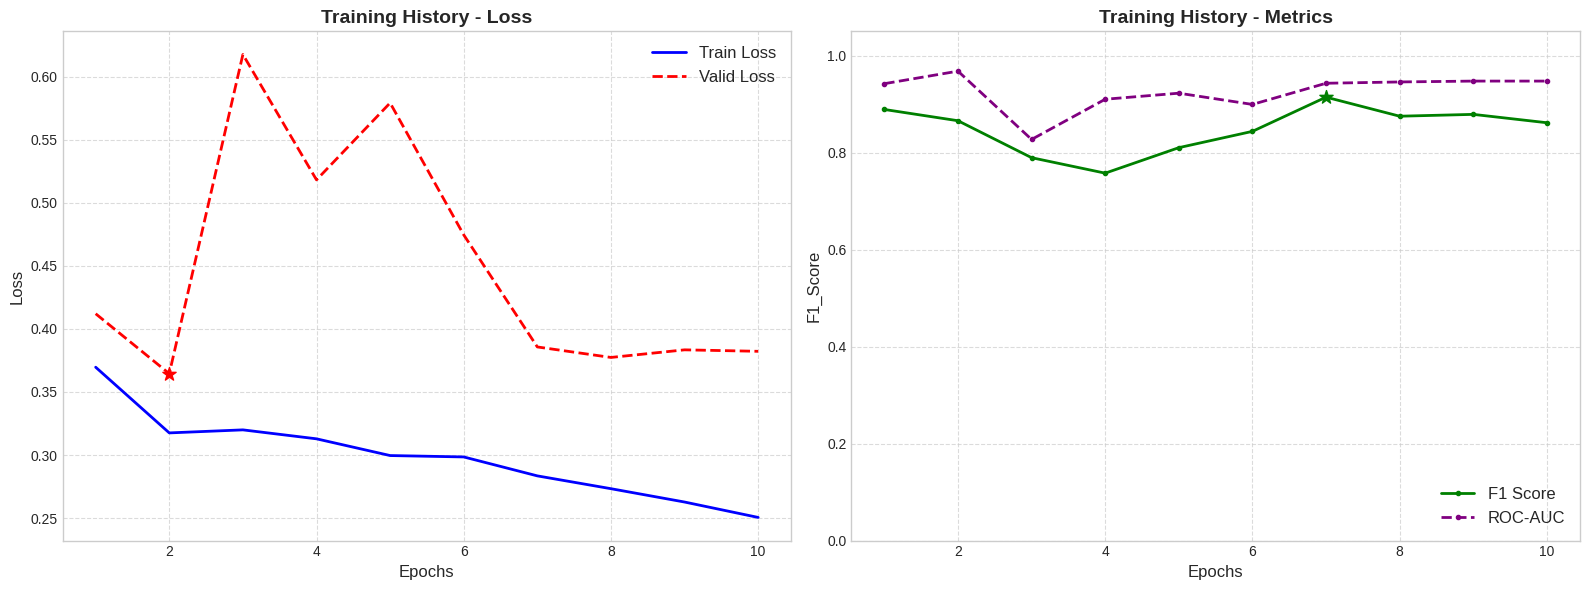

✅ Fold 4 Completed. F1 Score: 0.9143, AUC: 0.9430

--- 🚀 Starting Fold 5/5 ---
Fold 5: Train size=271, Validation size=67


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.702819,0.673817,0.492537,1.000000,0.492537,0.660000,0.872549,00:02
1,0.633102,0.659007,0.582090,1.000000,0.540984,0.702128,0.904635,00:02
2,0.596447,0.548081,0.761194,0.848485,0.717949,0.777778,0.859180,00:02


Better model found at epoch 0 with f1_score value: 0.66.
Better model found at epoch 1 with f1_score value: 0.7021276595744682.
Better model found at epoch 2 with f1_score value: 0.7777777777777778.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.430157,0.559826,0.776119,0.787879,0.764706,0.776119,0.875223,00:02
1,0.387740,0.488605,0.791045,0.848485,0.756757,0.800000,0.904635,00:02
2,0.344644,0.452837,0.850746,0.848485,0.848485,0.848485,0.904635,00:02
3,0.321722,0.738992,0.701493,0.787879,0.666667,0.722222,0.795900,00:02
4,0.303046,0.737777,0.716418,0.909091,0.652174,0.759494,0.874332,00:02
5,0.288755,0.493509,0.835821,0.878788,0.805556,0.840580,0.923351,00:02
6,0.276146,0.450720,0.835821,0.787879,0.866667,0.825397,0.930481,00:02
7,0.270724,0.451517,0.835821,0.818182,0.843750,0.830769,0.931373,00:02
8,0.254399,0.449808,0.850746,0.878788,0.828571,0.852941,0.929590,00:02
9,0.244166,0.458487,0.850746,0.878788,0.828571,0.852941,0.932264,00:02


Better model found at epoch 0 with f1_score value: 0.7761194029850745.
Better model found at epoch 1 with f1_score value: 0.8000000000000002.
Better model found at epoch 2 with f1_score value: 0.8484848484848486.
Better model found at epoch 8 with f1_score value: 0.8529411764705883.


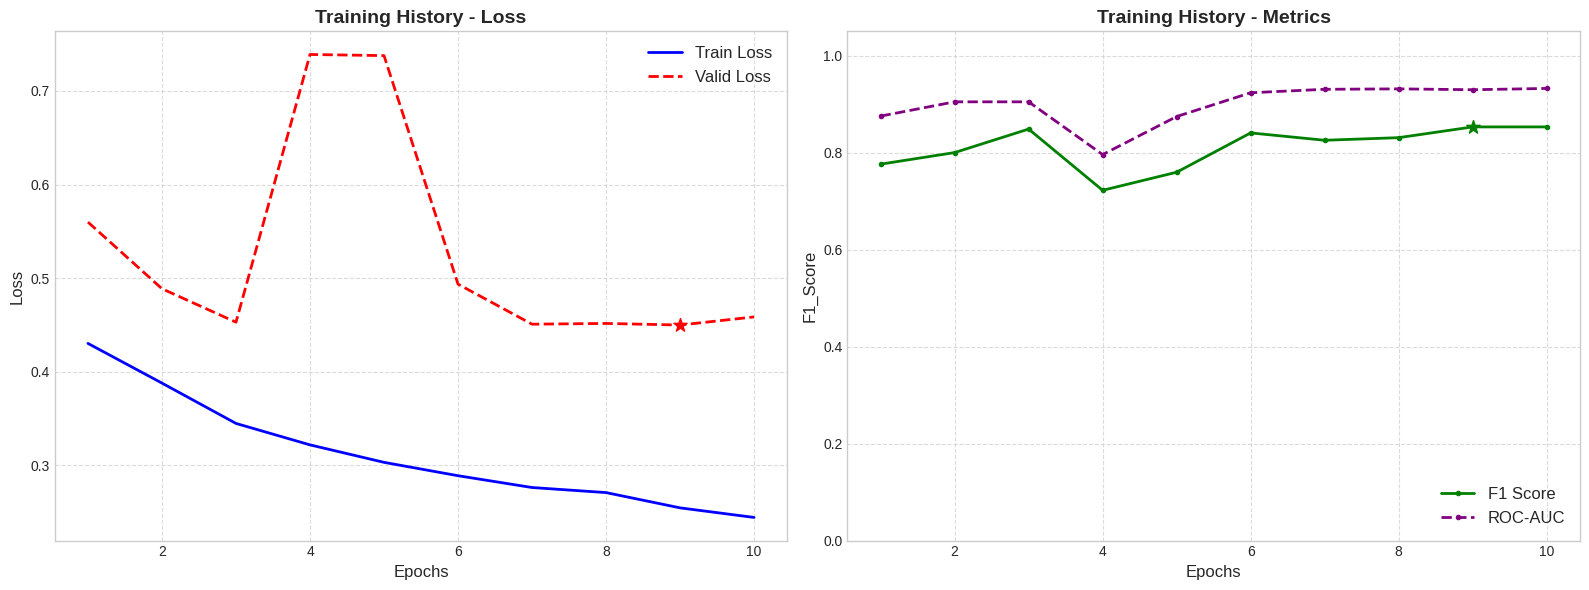

✅ Fold 5 Completed. F1 Score: 0.8529, AUC: 0.9296

--- K-Fold Evaluation ---
   Fold        F1       AUC
0     1  0.771084  0.740484
1     2  0.805970  0.826990
2     3  0.971429  0.985294
3     4  0.914286  0.942959
4     5  0.852941  0.929590
------------------------
Average F1 Score: 0.8631 ± 0.0809
Average AUC Score: 0.8851 ± 0.0996


In [43]:
print(f"\n--- Pretrained Model: MobileNet_v3 ---")

all_fold_metrics_mob = []
# Main loop
for fold, (train_index, val_index) in enumerate(kf.split(df, df['Glaucoma'])):

    print(f"\n--- 🚀 Starting Fold {fold+1}/{N_SPLITS} ---")

    train_df = df.iloc[train_index].reset_index(drop=True)
    val_df = df.iloc[val_index].reset_index(drop=True)

    print(f"Fold {fold+1}: Train size={len(train_df)}, Validation size={len(val_df)}")

    train_ds = GlaucomaDataset(train_df, train_transforms)
    val_ds = GlaucomaDataset(val_df, test_transforms)

    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=16)
    dls = DataLoaders(train_dl, val_dl)

    # Intialize the model
    torch.cuda.empty_cache()
    mobmodel = MobileModel()
    mobmodel = mobmodel.to("cuda:0")
    
    learner = Learner(dls, mobmodel, path=OUTPUT_DIR,
              metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()],
              loss_func=LabelSmoothingCrossEntropyFlat()
                    )

    save_cb = SaveModelCallback(monitor='f1_score', fname=f'fold_{fold+1}_bst_mobilenet', comp=np.greater)
    early_cb = EarlyStoppingCallback(monitor='f1_score', min_delta=0.005, patience=15)

    # Train and save the best model
    learner.fine_tune(
        epochs=10,
        base_lr=2e-3,
        freeze_epochs=3,
        cbs=[save_cb, early_cb]
    )
    plot_training_history(learner,fold,"MobileNet_v3")

    # Validate and record results
    learner.load(f'fold_{fold+1}_bst_mobilenet') 
    metrics = learner.validate()

    f1_score = metrics[4]
    roc_auc = metrics[5]
    all_fold_metrics_mob.append({'Fold': fold+1, 'F1': f1_score, 'AUC': roc_auc})

    print(f"✅ Fold {fold+1} Completed. F1 Score: {f1_score:.4f}, AUC: {roc_auc:.4f}")
 
    
final_results_df = pd.DataFrame(all_fold_metrics_mob)
print("\n--- K-Fold Evaluation ---")
print(final_results_df)
print("------------------------")
print(f"Average F1 Score: {final_results_df['F1'].mean():.4f} ± {final_results_df['F1'].std():.4f}")
print(f"Average AUC Score: {final_results_df['AUC'].mean():.4f} ± {final_results_df['AUC'].std():.4f}")